### Example for pruning a decoder

Prior to running this, make sure you have the [NLB MC_RTT dataset](https://dandiarchive.org/dandiset/000129) downloaded and select the file path in the `nlb_data_path` variable below.

Takes about 2min to run on an M1 CPU.

In [2]:
import torch
import torch.nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sparsebmi.utils as utils
import sparsebmi.models as models
import sparsebmi.config as config
import sparsebmi.training as training
import sparsebmi.pruning as pruning
import sparsebmi.data_loading as data_loading

%load_ext autoreload
%autoreload 2

device = utils.get_torch_device()
print(f"Using device: {device}")

Using device: cpu


Configuration options

In [ ]:
nlb_data_path = '.../000129/sub-Indy' # your path here

# which percent prunings to run
prune_pcts = [0, 50, 90, 95, 98, 99]

# which model to use
model_type = 'rnn'      # tcn or lstm or rnn

verbose_train = False

Load data, create model, train, prune, and test

In [4]:
# get config
if model_type == 'tcn':
    cfg = config.Config().add_config([config.default_cfg_data, config.cfg_tcn_nlb])

elif model_type == 'lstm':
    cfg = config.Config().add_config([config.default_cfg_data, config.cfg_lstm_nlb])
    
elif model_type == 'rnn':
    cfg = config.Config().add_config([config.default_cfg_data, config.cfg_rnn_nlb])

# load data
num_inputs = 130
num_outputs = 4
loader_train, loader_val, loader_test = data_loading.load_nlb(
    nlb_dataset_path=nlb_data_path,
    binsize_ms=cfg.binsize_ms,
    seq_len=cfg.hist_bins,
    batch_size=cfg.batch_size,
    train_val_test=cfg.train_val_test_split,
    pred_type=cfg.pred_type,
    normalize_x=cfg.normalize_x,
    normalize_y=cfg.normalize_y
)

# create model
if model_type == 'tcn':
    model = models.TCN(num_inputs, cfg.hist_bins, cfg.conv_num_filts, cfg.layer_size_list, num_outputs, cfg.dropout_p)
elif model_type == 'lstm':
    model = models.RNN(num_inputs, cfg.hidden_size, num_outputs, cfg.num_layers, 
                        rnn_type='lstm', drop_prob=cfg.dropout_p, dropout_input=0, device=device)
elif model_type == 'rnn':
    model = models.RNN(num_inputs, cfg.hidden_size, num_outputs, cfg.num_layers, 
                        rnn_type='rnn', drop_prob=cfg.dropout_p, dropout_input=0, device=device)
model.to(device=device)

Train: (14193, 130) (14193, 4)
Val: (2027, 130) (2027, 4)
Test: (4056, 130) (4056, 4)


RNN(
  (rnn): RNN(130, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=4, bias=True)
)

In [5]:
prune_pcts_rewind = [0] + prune_pcts    # evaluate the unpruned model as well

loss_fn = torch.nn.MSELoss()

# train/prune/rewind (the function handles creating the optimizer and pruner)
_, prune_vals, trained_models = training.train_prune_rewind_model(model, prune_pcts_rewind, loader_train, loader_val, loss_fn, cfg, device=device)



starting pruning from 0% to 0%...
validation corr = [0.81136294 0.87960588 0.81692772 0.85550249], mse = 0.28248175978660583


starting pruning from 0% to 50%...
validation corr = [0.78901819 0.87914535 0.80590553 0.86560562], mse = 0.2841881215572357


starting pruning from 50% to 90%...
validation corr = [0.80720734 0.89413323 0.81800075 0.87157604], mse = 0.2716754078865051


starting pruning from 90% to 95%...
validation corr = [0.81485198 0.86533493 0.81693712 0.85988021], mse = 0.2903801500797272


starting pruning from 95% to 98%...
validation corr = [0.80170103 0.86005888 0.78915725 0.84494738], mse = 0.3037645220756531


starting pruning from 98% to 99%...
validation corr = [0.79411377 0.84713881 0.73403102 0.80862379], mse = 0.354372501373291


 Final percent pruned = 98.49


In [6]:
# get test performance

resultsdflist = []    
for prune_pct, model in zip(prune_vals, trained_models):
    model.eval().to(device)
    test_corr, test_mse = training.eval_model(model, loader_test, device=device)
    print(f'Prune pct: {prune_pct}, Test corr: {test_corr}, Test MSE: {test_mse}')

    # calc actual prune pct (create a dummy pruner to finalize the pruning masks)
    pruner = pruning.ModelPruner(model, model.get_pruning_params())
    pruner.finalize()
    actual_prune_pct = pruning.get_percent_pruned(model, verbose=False)

    # save
    nonzero_weights, total_weights = pruning.count_non_zero_weights(model)
    thisresult = {
        'desired_prune_pct': [prune_pct],
        'actual_prune_pct': [actual_prune_pct],
        'num_params': [total_weights],
        'num_nonzero_params': [nonzero_weights],
        'corr': [test_corr],
        'avgcorr': [np.mean(test_corr)],
        'mse': [test_mse],
        'prune_type': ['prune_rewind'],
        'model_type': [model_type],
    }
    resultsdflist.append(pd.DataFrame(thisresult))


resultsdf = pd.concat(resultsdflist)

Prune pct: 0, Test corr: [0.7773942  0.83054269 0.84882597 0.83609913], Test MSE: 0.36089587211608887
Prune pct: 50, Test corr: [0.76849391 0.83930993 0.84280263 0.83388022], Test MSE: 0.3525795638561249
Prune pct: 90, Test corr: [0.79846083 0.84661961 0.85341636 0.85371046], Test MSE: 0.32550764083862305
Prune pct: 95, Test corr: [0.81435447 0.85510366 0.87360244 0.85961128], Test MSE: 0.3014422357082367
Prune pct: 98, Test corr: [0.80475367 0.85177912 0.85094433 0.84058324], Test MSE: 0.3235800564289093
Prune pct: 99, Test corr: [0.75629086 0.82627048 0.79242879 0.81897602], Test MSE: 0.39704373478889465


Plot MSE vs number of parameters

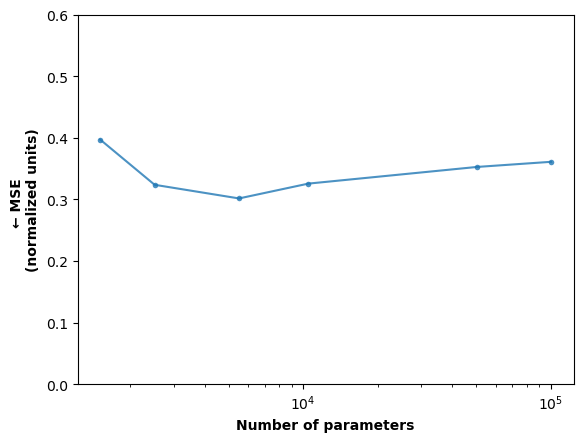

In [14]:

errbar = 'se'
kwargs = {'alpha': 0.8, 'marker': 'o', 'markersize': 4, 'linewidth': 1.5, 'markeredgewidth': 0}

xvar = 'num_nonzero_params'
yvar = 'mse'

sns.lineplot(data=resultsdf, x=xvar, y=yvar, errorbar=errbar, **kwargs)

plt.xscale('log')
plt.ylim([0, 0.6])
plt.ylabel('← MSE \n(normalized units)', fontweight='bold')
plt.xlabel('Number of parameters', fontweight='bold')
plt.show()